In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator


In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/"

camera_program = 4

# Movie maker settings
enable_photoZ_interact = False
initialize_photoZ = False

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [4]:
# map data files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):

    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = parse_date(subdir)

        # take selected zda and expand into separate subdir for each zda file
        print(os.listdir(selected_zda_dir))
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                print("\n", selected_zda_dir + "/" + zda_file)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]

                if subdir not in data_map:
                    data_map[subdir] = {}
                if slic_id not in data_map[subdir]:
                    data_map[subdir][slic_id] = {}
                if loc_id not in data_map[subdir][slic_id]:
                    data_map[subdir][slic_id][loc_id] = {
                        'zda_files': [],
                        'roi_file': [],
                    }
                data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)
                data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + "/slice" + str(slic_id) + "_rois.dat"


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/
invalid literal for int() with base 10: '' could not process date from:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/
['02_01_01.zda', '02_01_02.zda', '02_01_03.zda', '02_01_04.zda', '02_01_05.zda', '02_01_06.zda', '02_01_07.zda', 'hidden', 'slice2_rois.dat', 'slice2_rois_80uA-4.dat', 'slice2_rois_80uA.dat', 'trace80uA_02_01_04.dat', 'trace80uA_02_01_07.dat', 'traces_02_01_01.dat', 'trace_02_01_01.dat', 'trace_02_01_02.dat', 'trace_02_01_03.dat', 'trace_02_01_04.dat', 'trace_02_01_05.dat', 'trace_02_01_06.dat', 'trace_02_01_07.dat']

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_01.zda

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_02.zda

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_03.zda

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta

In [5]:
# now load these ROI files into PhotoZ and extract latency and halfwidth dat files
# go through the ZDA files and extract amp arrays 

if enable_photoZ_interact:
    pa.alert("Set measure window width to > 70 for half-width measurement.")
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:
        roi_file_opened = False

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file']
            
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                if not os.path.exists(zda_file):
                    print("ZDA file does not exist, skipping.")
                    continue
                
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)

                if enable_photoZ_interact and not roi_file_opened:
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_file)
                    print("Opened ROI file", roi_file)
                    roi_file_opened = True

                slic_loc_id_rec_id = zda_file.split("/")[-1].split(".")[0]
                    
                # save half-width values from PhotoZ
                hw_filename = subdir + "/" + "hw_" + slic_loc_id_rec_id + ".dat" 
                if enable_photoZ_interact:
                    pass #aPhz.select_half_width_trace_value()
                    #aPhz.save_trace_values(hw_filename)

                # save amp values from PhotoZ
                amp_filename = subdir + "/" + "amp_" + slic_loc_id_rec_id + ".dat" 
                if enable_photoZ_interact:
                    pass #aPhz.select_maxamp_trace_value()
                    #aPhz.save_trace_values(amp_filename)
                    
                # save latency values from PhotoZ
                lat_filename = subdir + "/" + "lat_" + slic_loc_id_rec_id + ".dat" 
                if enable_photoZ_interact:
                    pass
                    #aPhz.select_latency_trace_value()
                    #aPhz.save_trace_values(lat_filename)

                trace_filename = selected_zda_dir + "/" + "trace_" + slic_loc_id_rec_id + ".dat"
                if enable_photoZ_interact:
                    aPhz.save_current_traces(trace_filename, go_to_tab=True)

                if 'amp' not in data_map[subdir][slic_id][loc_id]:
                    data_map[subdir][slic_id][loc_id]['amp'] = []
                    data_map[subdir][slic_id][loc_id]['hw'] = []
                    data_map[subdir][slic_id][loc_id]['lat'] = []
                    data_map[subdir][slic_id][loc_id]['trace'] = []

                data_map[subdir][slic_id][loc_id]['amp'].append(amp_filename)
                data_map[subdir][slic_id][loc_id]['hw'].append(hw_filename)
                data_map[subdir][slic_id][loc_id]['lat'].append(lat_filename)
                data_map[subdir][slic_id][loc_id]['trace'].append(trace_filename)

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_03.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_04.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_05.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_06.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_07.zda


In [6]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

{'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/': {2: {1: {'zda_files': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_01.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_02.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_03.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_04.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_05.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_06.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//02_01_07.zda'], 'roi_file': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//slice2_rois.dat', 'amp': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24

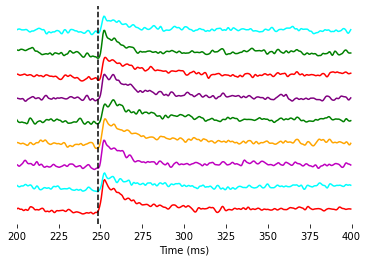

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

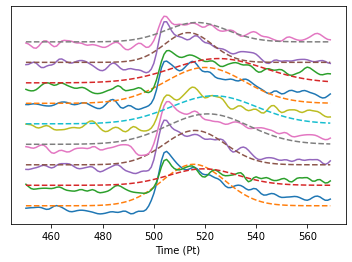

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//trace_02_01_02.dat
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


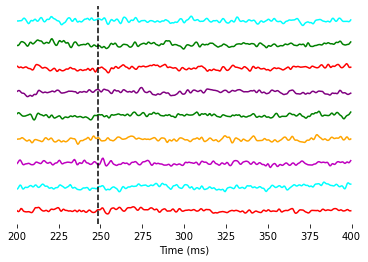

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


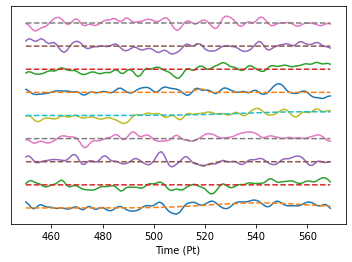

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//trace_02_01_03.dat
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


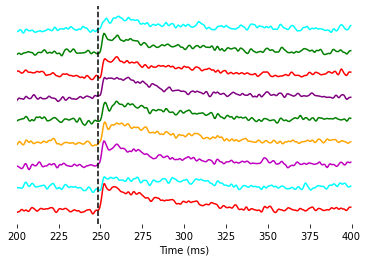

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

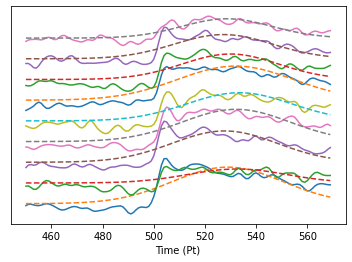

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//trace_02_01_04.dat
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


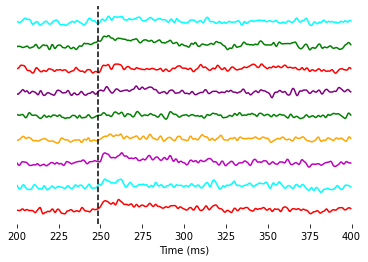

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

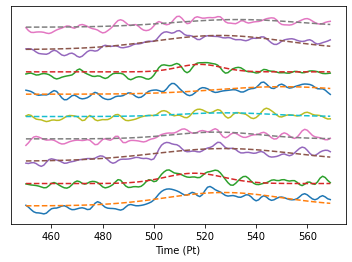

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


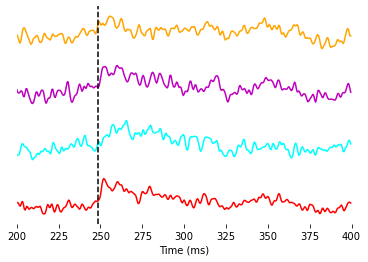

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


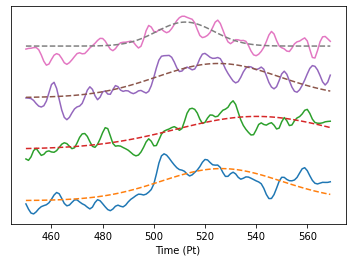

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//trace_02_01_05.dat
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


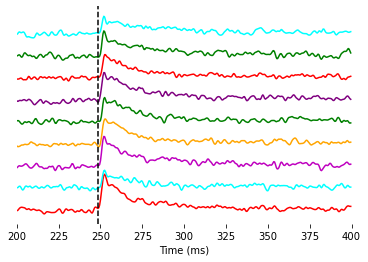

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

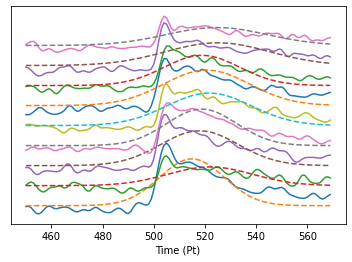

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//trace_02_01_06.dat
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


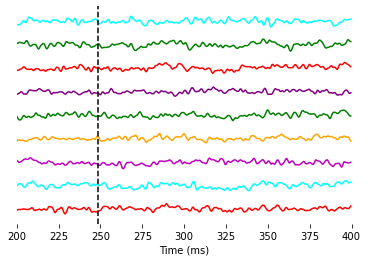

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

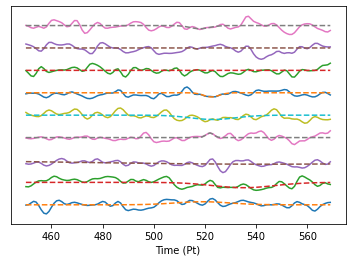

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24//selected_zda//trace_02_01_07.dat
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


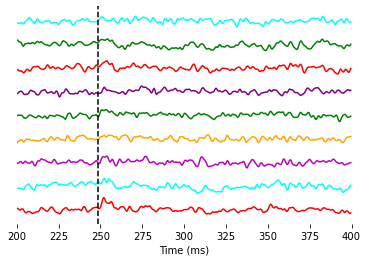

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


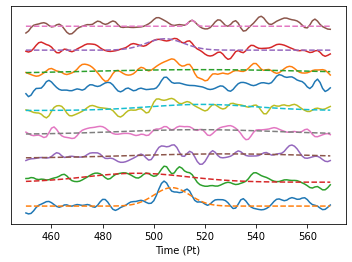

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/ 2_1


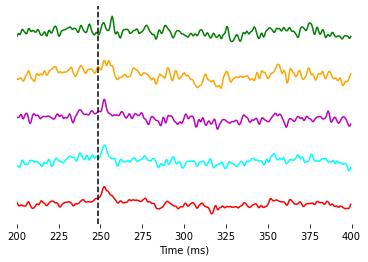

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, 

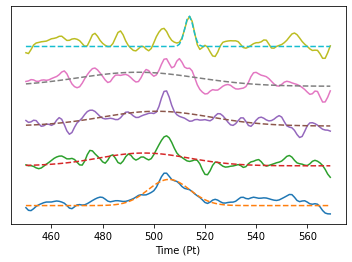

In [19]:
# plot traces
print(data_map)
for subdir in data_map:
    print(subdir)
    date = parse_date(subdir)
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            for i, zda_file in enumerate(data_map[subdir][slic_id][loc_id]['zda_files']):
                amp_filename = data_map[subdir][slic_id][loc_id]['amp'][i]
                hw_filename = data_map[subdir][slic_id][loc_id]['hw'][i]
                lat_filename = data_map[subdir][slic_id][loc_id]['lat'][i]
                trace_filename = data_map[subdir][slic_id][loc_id]['trace'][i]
                print(trace_filename)
                sample_traces = read_traces_file(trace_filename)

                other_tracefilename = trace_filename.replace("trace_", "trace80uA_")
                traces_to_plot = [sample_traces]
                if os.path.exists(other_tracefilename):
                    other_traces = read_traces_file(other_tracefilename)
                    traces_to_plot.append(other_traces)
                
                for trace in traces_to_plot:
                    tm = TraceMetrics(trace)
                    print(date, slic_loc_id)
                    tm.show_traces(measure_window=[400, 800], 
                            legend=False, 
                            colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                    'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                            stim_time=248.3,
                            headroom=2,
                                    )
                    # apply alpha function fit and show the trace
                    #tm = TraceMetrics(trace)
                    fit_metadata = tm.fit_trace_to_function('gaussian', 
                                                            plot=True,
                                                            measure_window=(450,570),
                                                            p0=[2.0, .7, 516],
                                                            headroom=1)
                
                #sample_traces = sample_traces.drop(columns=[ 'ROI5',
                #                            'ROI6', 'ROI7', 'ROI9', 
                #                            'ROI10', 'ROI11', 'ROI12',])

                        

## 